In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import os
import plotly.express as px
import seaborn as sns
import math
import scipy
import scipy.stats as ss

from scipy.stats import spearmanr
from sklearn.metrics.pairwise import nan_euclidean_distances 
import itertools
from itertools import tee
from itertools import permutations


import scipy as sp
from scipy import stats
import researchpy as rp
import scipy.stats as stat
import openpyxl

In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,  RocCurveDisplay, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import scipy.stats as st
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error


# Load metadata for samples and genes in GTEx

In [16]:
key_modules_genes = pd.read_csv(f'key_modules_genes.csv')
key_modules_genes.set_index('Unnamed: 0', inplace=True)

In [10]:
from gseapy import Biomart
bm = Biomart()

results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'])
results.tail()

,ensembl_gene_id,external_gene_name,entrezgene_id,go_id
475449,ENSG00000232679,LINC01705,105372950,NaN
475450,ENSG00000200033,RNU6-403P,<NA>,NaN
475451,ENSG00000228437,LINC02474,<NA>,NaN
475452,ENSG00000229463,LYST-AS1,<NA>,NaN
475453,ENSG00000229291,LINC02768,<NA>,NaN


In [11]:
def mapping_dict(key_modules_genes, results):
    mapping_dict = dict(zip(results["ensembl_gene_id"].tolist(), results["external_gene_name"].tolist()))
    mapping_dict = {k: v for k, v in mapping_dict.items() if pd.notnull(v)}
    key_modules_genes_map = key_modules_genes.drop([i for i in key_modules_genes.iloc[:, :-2].columns if i not in mapping_dict.keys()], axis=1)
    key_modules_genes_map = key_modules_genes_map.rename(mapping_dict, axis=1)
    key_modules_genes_map = key_modules_genes_map.loc[:,~key_modules_genes_map.columns.duplicated()]
    return key_modules_genes_map

# LASSO - feature selection 

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
labels = pd.factorize(key_modules_genes["Group"])[0]

skf = StratifiedKFold(n_splits=5)
X_p = key_modules_genes.iloc[:, :-2]
y_p = labels


best_features = Lasso(alpha=0.01)
best_features.fit(X_p, y_p)
scores = cross_val_score(best_features, X_p, y_p, cv=skf, scoring = 'roc_auc')
print ("roc_auc = %f (%f)" % (scores.mean(), scores.std()))
        
      
feature_coefficients = pd.Series(best_features.coef_, index=X_p.columns)
selected_features = feature_coefficients[feature_coefficients != 0].index

print(f"Number of selected features: {len(selected_features)}")
print(f"Selected features : {list(selected_features)}")

key_modules_genes_selected = pd.concat([key_modules_genes[selected_features], key_modules_genes[["Group", "AGE"]]], axis=1)
#key_modules_genes_selected.to_csv("key_modules_genes_selected.csv")

roc_auc = 0.673016 (0.094008)
Number of selected features: 66
Selected features : ['ENSG00000242802', 'ENSG00000177082', 'ENSG00000170873', 'ENSG00000170345', 'ENSG00000157224', 'ENSG00000144959', 'ENSG00000144199', 'ENSG00000131910', 'ENSG00000129991', 'ENSG00000121766', 'ENSG00000120158', 'ENSG00000116791', 'ENSG00000239857', 'ENSG00000204634', 'ENSG00000204305', 'ENSG00000203667', 'ENSG00000188038', 'ENSG00000185324', 'ENSG00000185220', 'ENSG00000173531', 'ENSG00000173258', 'ENSG00000124302', 'ENSG00000114841', 'ENSG00000243989', 'ENSG00000205213', 'ENSG00000198417', 'ENSG00000196091', 'ENSG00000185650', 'ENSG00000184925', 'ENSG00000182508', 'ENSG00000171766', 'ENSG00000166451', 'ENSG00000165821', 'ENSG00000164776', 'ENSG00000164087', 'ENSG00000148680', 'ENSG00000148604', 'ENSG00000144369', 'ENSG00000141401', 'ENSG00000137142', 'ENSG00000136160', 'ENSG00000131773.1', 'ENSG00000189184', 'ENSG00000185187', 'ENSG00000163378', 'ENSG00000135480.1', 'ENSG00000172345.1', 'ENSG00000168389',

# Test classification - Nested Cross-Validation 

In [18]:
def plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc):
    plt.figure(figsize=(7,7))
    plt.style.use("seaborn-ticks")
    plt.plot(base_fpr, mean_tprs, 'b', label=f'AUC = {roc_auc:.3f}')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
    plt.plot([0, 1], [0, 1],'r--', label='Random')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC Curve for RF classifier')

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"plots/roc_curve_Random Forest.png", dpi=300)
    plt.show()

In [21]:
def aging_classification (df, model):

    skf = StratifiedKFold(n_splits=5)
    X = df.iloc[:, :-2].to_numpy()
    y = pd.factorize(df["Group"])[0]

    base_fpr = np.linspace(0, 1, 101)
    roc_all = []
    tprs = []
    aurocs = []

    accs, precs, recs, f1s = [], [], [], []


    # configure the cross-validation procedure
    skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # enumerate splits
    outer_results = list()
    for train_ix, test_ix in skf_outer.split(X,y):
     # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        # configure the cross-validation procedure
        skf_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

        if(model== 'xgboost'):
            model_tune = xgb.XGBClassifier()
            random_grid = {'n_estimators': [100, 150, 200, 250, 300] ,
                            'max_depth': [6, 8, 10, 12],
                            'learning_rate':[.3, .1, .03, .01, .003, .001],
                            #"min_child_weight": [1, 2, 4, 8] ,
                            "colsample_bytree": [.8, .9, 1.0],
                            "subsample": [.8, .9, 1.0]}


        if(model== 'RF'):
            model_tune = RandomForestClassifier()
            random_grid = { 'n_estimators': [100, 150, 200, 250, 300] ,
                           'max_features': ['auto', 'sqrt', 'log2'],
                           'max_depth' : [4,5,6,7,8, 10, 12],
                           'criterion' :['gini', 'entropy']}
            
        scoring = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
        # define search
        model_hyper = RandomizedSearchCV(model_tune,random_grid, n_iter = 5, cv=skf_inner, random_state=42, 
                                       n_jobs = -1, refit='roc_auc', scoring=scoring, return_train_score = True)
        # execute search
        result = model_hyper.fit(X_train, y_train)

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        # store the result
        outer_results.append(acc)
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))

        accs.append(accuracy_score(y_test, yhat))
        precs.append(precision_score(y_test, yhat))
        recs.append(recall_score(y_test, yhat))
        f1s.append(f1_score(y_test, yhat))   
        fpr, tpr, _ = roc_curve(y_test, model_hyper.predict_proba(X_test)[:,1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)


    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    print("%0.2f accuracy with a standard deviation of %0.2f" % (np.mean(aurocs), np.std(aurocs)))
    roc_auc = auc(base_fpr, mean_tprs)
    print(f'Mean AUC: {np.mean(roc_auc)}, Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean F1: {np.mean(f1s)}')

    plot_roc_curve(base_fpr, mean_tprs, tprs_lower, tprs_upper, roc_auc)

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

# Random forest model

>acc=0.588, est=0.739, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
>acc=0.647, est=0.687, cfg={'n_estimators': 300, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy'}
>acc=0.625, est=0.701, cfg={'n_estimators': 100, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}
>acc=0.688, est=0.695, cfg={'n_estimators': 100, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}
>acc=0.750, est=0.683, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
nan accuracy with a standard deviation of nan
Mean AUC: 0.7091711111111111, Mean Accuracy: 0.6595588235294118, Mean Precision: 0.6597435897435897, Mean Recall: 0.8777777777777779, Mean F1: 0.7506022962544702


C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


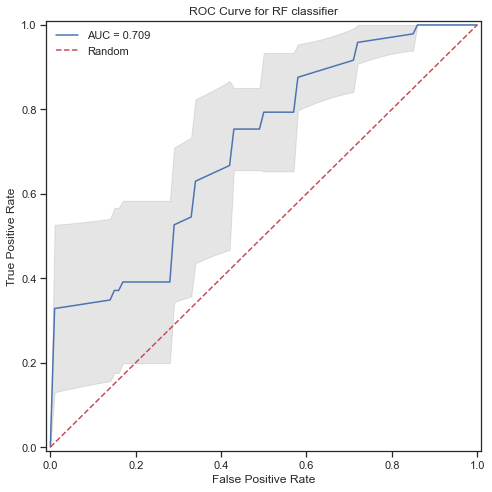

Accuracy: 0.660 (0.055)


In [96]:
# all genes
aging_classification (key_modules_genes, 'RF')

>acc=0.706, est=0.900, cfg={'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
>acc=0.824, est=0.934, cfg={'n_estimators': 100, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'gini'}
>acc=0.688, est=0.895, cfg={'n_estimators': 300, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy'}
>acc=0.875, est=0.880, cfg={'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy'}
>acc=0.938, est=0.876, cfg={'n_estimators': 300, 'max_features': 'auto', 'max_depth': 12, 'criterion': 'entropy'}
nan accuracy with a standard deviation of nan
Mean AUC: 0.8886304444444445, Mean Accuracy: 0.8058823529411765, Mean Precision: 0.7733266733266734, Mean Recall: 0.96, Mean F1: 0.8532919254658384


C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


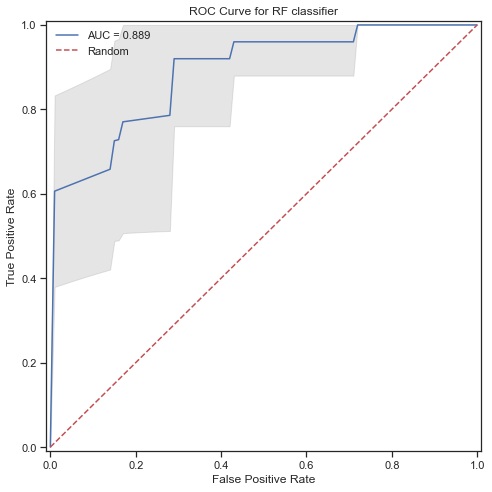

Accuracy: 0.806 (0.096)


In [101]:
# selected genes with LASSO
aging_classification (key_modules_genes_selected, 'RF')

# Xgboost model

>acc=0.588, est=0.736, cfg={'subsample': 0.8, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
>acc=0.412, est=0.646, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
>acc=0.500, est=0.544, cfg={'subsample': 0.8, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
>acc=0.500, est=0.615, cfg={'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.8}
>acc=0.750, est=0.663, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
nan accuracy with a standard deviation of nan
Mean AUC: 0.6007333333333333, Mean Accuracy: 0.55, Mean Precision: 0.6050505050505051, Mean Recall: 0.7288888888888888, Mean F1: 0.6544444444444445


C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


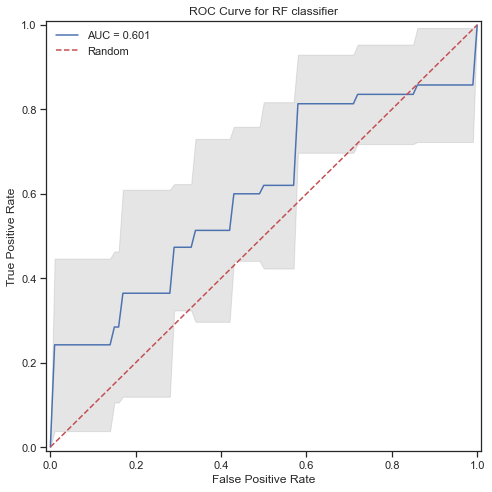

Accuracy: 0.550 (0.115)


In [99]:
# all genes
aging_classification (key_modules_genes, 'xgboost')

>acc=0.706, est=0.786, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.647, est=0.780, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.750, est=0.764, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
>acc=0.500, est=0.738, cfg={'subsample': 0.8, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
>acc=0.938, est=0.795, cfg={'subsample': 0.9, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
nan accuracy with a standard deviation of nan
Mean AUC: 0.7426444444444444, Mean Accuracy: 0.7080882352941177, Mean Precision: 0.7171717171717171, Mean Recall: 0.8088888888888889, Mean F1: 0.7594227994227994


C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\brsha\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


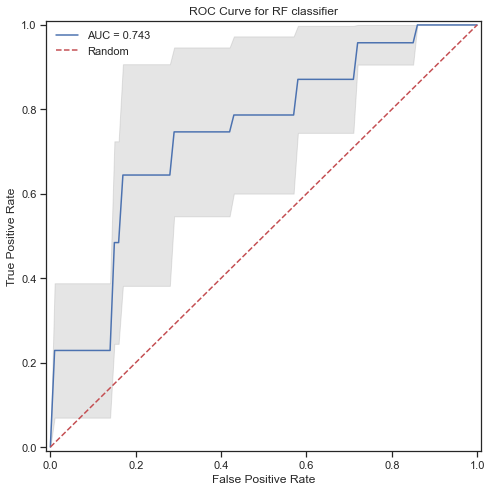

Accuracy: 0.708 (0.142)


In [175]:
# selected genes with LASSO
aging_classification (key_modules_genes_selected, 'xgboost')

In [40]:
def mapping_dict(df, go_ensembel2geneName):
    mapping_dict = dict(zip(go_ensembel2geneName["ensembl_gene_id"].tolist(), go_ensembel2geneName["external_gene_name"].tolist()))
    mapping_dict = {k: v for k, v in mapping_dict.items() if pd.notnull(v)}
    df_map = df.drop([i for i in df.index if i not in mapping_dict.keys()], axis=0)
    df_map = df_map.rename(mapping_dict, axis=0)
    return df_map

def feature_importance(key_modules_genes): 
    from sklearn.inspection import permutation_importance

    
    #key_modules_genes.iloc[:, :-2] = StandardScaler().fit_transform(key_modules_genes.iloc[:, :-2].to_numpy())
    key_modules_genes.iloc[:, :-2] = key_modules_genes.iloc[:, :-2].to_numpy()
    labels = pd.factorize(key_modules_genes["Group"])[0]
    
    skf_p = StratifiedKFold(n_splits=3)
    X_p = key_modules_genes.iloc[:, :-2].to_numpy()
    y_p = labels
    X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=20)
    forest = RandomForestClassifier()
    forest.fit(X_p, y_p)

    result = permutation_importance(
        forest, X_p, y_p, n_repeats=30, scoring="roc_auc"
    )  
    
    forest_importances  = pd.Series(forest.feature_importances_,index=key_modules_genes.iloc[:, :-2].columns).sort_values(ascending=False)
    df = forest_importances.to_frame()

    df = df.sort_values(by=0, key=abs, ascending=False)
    return df   

In [41]:
df_importance = feature_importance(key_modules_genes_selected)
df_map = mapping_dict(df_importance, results)

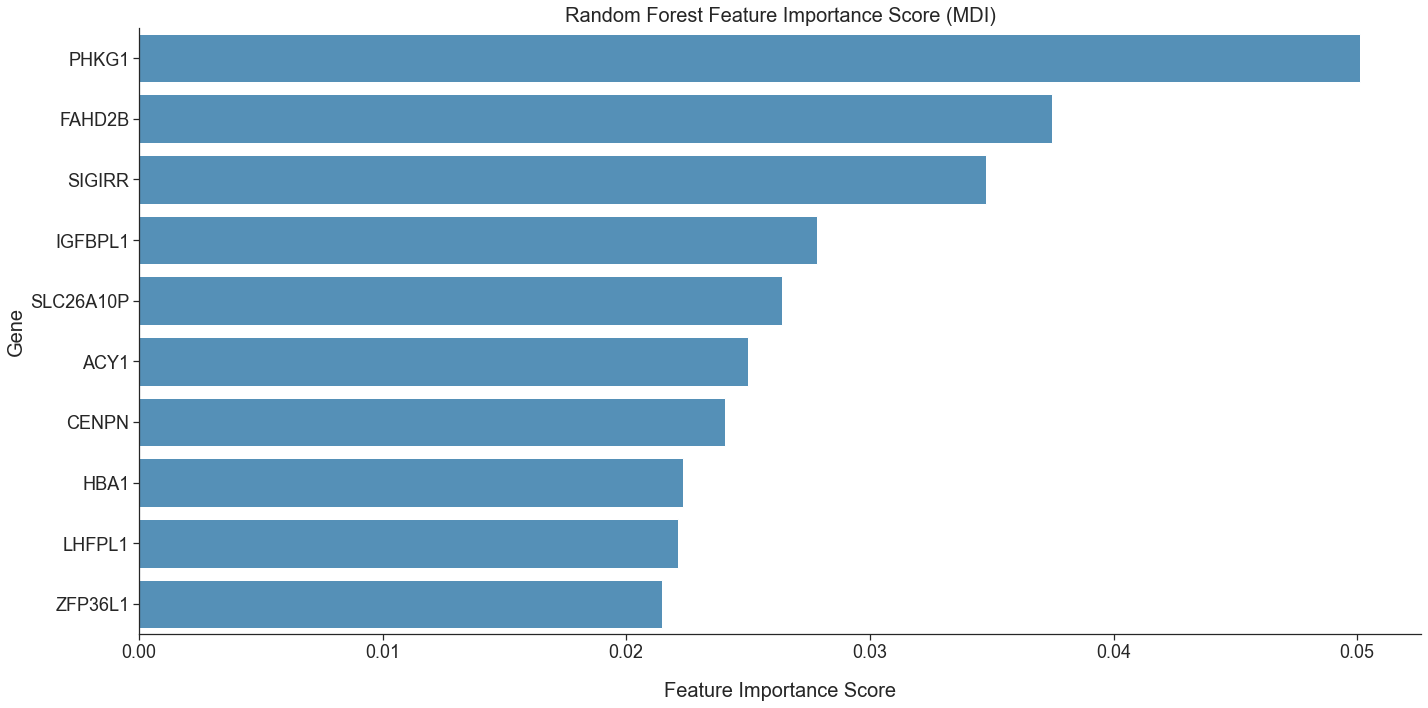

In [142]:
#Feature Importance
feature_imp = df_map[:10]

#Barplot
plt.figure(figsize = (20,10))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.barplot(x=feature_imp[0], y=feature_imp.index.to_list(), color = '#4594c7')
sns.despine()
plt.title('Random Forest Feature Importance Score (MDI)', fontsize=20)
plt.xlabel('Feature Importance Score', fontsize=20,labelpad=20)
plt.ylabel('Gene', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f"plots/Random Forest Feature Importance Score (MDI).png", dpi=300)